In [41]:
import numpy as np
from numpy import genfromtxt
from trueskill import TrueSkill, Rating, quality_1vs1, rate_1vs1
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
from matplotlib import cm
from scipy import stats
import operator as op
import pandas as pd
from ast import literal_eval
from mpl_toolkits.mplot3d import Axes3D
import math
import sys

# Griewank  function
## Optimization Methods
----
https://www.sfu.ca/~ssurjano/griewank.html

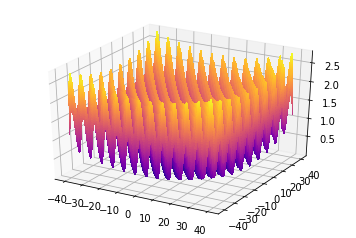

In [2]:
def griewank(*X, **kwargs):
    A = kwargs.get('A', 10)
    summ = 1 + sum([(x**2) for x in X])/4000
    I = 1
    mlty = 1
    for x in X:
        mlty = mlty * np.cos(x/math.sqrt(I))
        I = I + 1
    return summ - mlty
        

if __name__ == '__main__':
    X = np.linspace(-40, 40, 1100)    
    Y = np.linspace(-40, 40, 1100)    
    
    X, Y = np.meshgrid(X, Y)

    Z = griewank(X, Y, A=10)

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)    
    plt.savefig('griewank', format='pdf')

## Simulated Annealing
---
### Cooling Schedule

Now we must define the functions that constitute our cooling schedule. We reduce the temperature by a multiplicative factor of 0.8, and increase the epoch length by a factor of 1.2

In [5]:
tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

### Running the Algorithm

We define the `sa` function that takes a set of initial conditions, on temperature, length of epoch, and starting point, the energy function, the number or opochs to run, the cooling schedule, and the proposal, and implements the algorithm defined above. Our algorithms structure is that of running for some epochs during which we reduce the temperature and increase the epoch iteration length. This is somewhat wasteful, but simpler to code, although it is not too complex to build in stopping conditions.

In [155]:
def sa(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc,sigma = 0.75,x1 = 20,x0 = 0.5,alpha = -1.5):
    # out plot
    OUT_List_Simanneal = []
    Iterations = []
    
    accumulator=[]
    best_solution = old_solution = initials['solution']
    T=initials['T']
    length=initials['length']
    best_energy = old_energy = energyfunc(old_solution)
    accepted=0
    total=0
    
    best_index=total
    best_temp=T
    
    
    for index in range(epochs):
        # print("Epoch", index)
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
            sys.stdout.write("\r Temperature " + str(T))
            sys.stdout.flush()
        # print("Temperature", T, "Length", length)
        for it in range(length):
            Iterations.append(total)
            OUT_List_Simanneal.append(old_energy)
            total+=1
            new_solution = np.copy(old_solution)
            for y in new_solution:
                if proposalfunc == 'rdmGauss':
                    y[0] = y[0] + rdmGauss(sigma = sigma)
                else:
                    y[0] = y[0] + rdmSimetricPoerLow(x1 = x1, x0 = x0, alpha = alpha)
                if y[0] < -600 :
                    y[0] = -600
                elif y[0] > 600:
                    y[0] = 600
                    
            # new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            # Use a min here as you could get a "probability" > 1
            alphaLoc = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alphaLoc)):
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                #OUT_List_Simanneal.append(new_energy)
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
                #OUT_List_Simanneal.append(old_energy)
    
    best_meta=dict(index=best_index, temp=best_temp)
    # print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator, OUT_List_Simanneal, Iterations

In [43]:
# http://mathworld.wolfram.com/RandomNumber.html
# https://stackoverflow.com/questions/918736/random-number-generator-that-produces-a-power-law-distribution
def rdmSimetricPoerLow(x1 = 3, x0 = 0.1, alpha = -1.5):
    y = np.random.uniform(0,1,1)
    x = math.pow((math.pow(x1, (alpha + 1)) - math.pow(x0, (alpha + 1)))*y + math.pow(x0, (alpha + 1)),(1/(alpha+1)))
    sign = np.random.uniform(0,1,1)
    return x if sign > 0.5 else -x

In [44]:
def rdmGauss(sigma = 0.2, mu = 0):
    return np.random.normal(mu, sigma, 1)

In [45]:
def Griewank(fevalMtx):
    summ = 1 + sum([(x[0]**2) for x in fevalMtx])/4000
    I = 1
    mlty = 1
    for x in fevalMtx:
        mlty = mlty * np.cos(x[0]/math.sqrt(I))
        I = I + 1
    return summ - mlty



In [46]:
def GriewankGradient(fevalMtx):
    delta = np.zeros((fevalMtx.shape[0], 1))
    mlty = 1
    I = 1
    for x in fevalMtx:
        mlty = mlty * np.cos(x[0]/math.sqrt(I))
        I = I + 1
    I = 1    
    for i in range(fevalMtx.shape[0]):
        delta[i][0] = (fevalMtx[i][0] * 2)/4000
        kmul = np.cos(fevalMtx[i][0]/math.sqrt(I))
        kmul = mlty/kmul
        inDelta = np.sin(fevalMtx[i][0]/math.sqrt(I))/math.sqrt(I)
        delta[i][0] = delta[i][0] + kmul*inDelta
        I = I + 1
   
    return delta

In [47]:
def min_GriewankPowerLaw(fevalMtx,  x1 = 20, x0 = 0.5, alpha = -1.5):
    Y = np.copy(fevalMtx)
    for y in Y:
        y[0] = y[0] + rdmSimetricPoerLow( x1 = x1, x0 = x0, alpha = alpha)
        
        if y[0] < -600 :
            y[0] = -600
        elif y[0] > 600:
            y[0] = 600

    prev = Griewank(fevalMtx);
    new = Griewank(Y);
    
    if new <= prev:
        return new, Y
    else:
        return prev, fevalMtx
            

In [112]:
def min_GriewankHill(fevalMtx,sigma = 0.7):
    Y = np.copy(fevalMtx)
    for y in Y:
        y[0] = y[0] + rdmGauss(sigma = sigma)
        
        if y[0] < -600 :
            y[0] = -600
        elif y[0] > 600:
            y[0] = 600
    
    prev = Griewank(fevalMtx);
    new = Griewank(Y);
    
    if new <= prev:
        return new, Y
    else:
        return prev, fevalMtx

In [134]:
def min_GriewankGradiente(fevalMtx, delta, alpha = 0.0001, miu = 0.7):
    alpha = alpha;
    miu = miu;
    grad = GriewankGradient(fevalMtx)
    Y = np.copy(fevalMtx)
    for i in range(fevalMtx.shape[0]):
        delta[i][0] =  miu * delta[i][0] - grad[i][0] * alpha
        Y[i][0] = Y[i][0] + delta[i][0]
        
        if Y[i][0] < -600 :
            Y[i][0] = -600
        elif Y[i][0] > 600:
            Y[i][0] = 600
        
    
    new = Griewank(Y);
    
    return new, Y, delta 

# min_GriewankPowerLaw
## 2D

 Iteration 29

mean: 0.19970494390540192
std: 0.11941485946552699
median: 0.1924491054778632
min: 0.01416466863815724
max: 0.4302342648135826


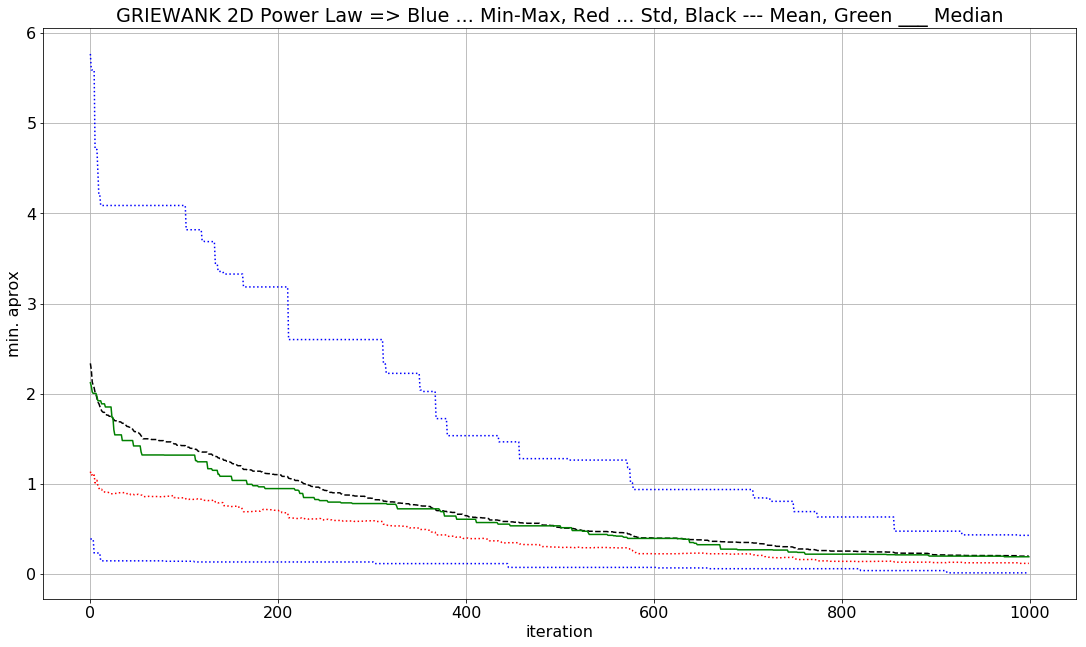

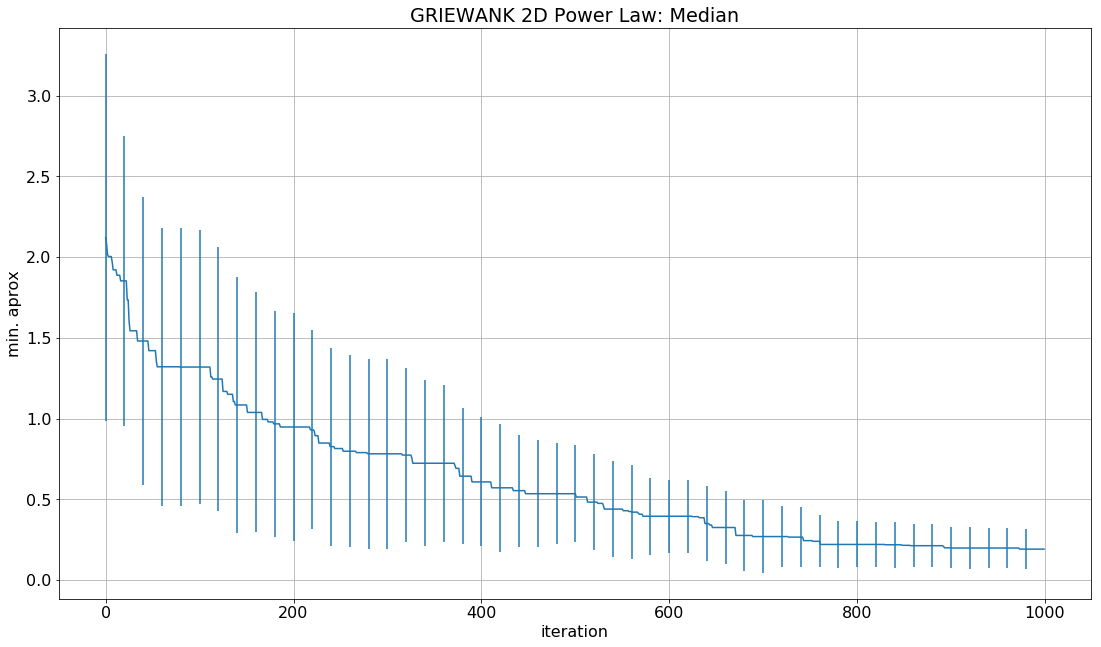

In [61]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-100, high=100, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm = min_GriewankPowerLaw(fevalRdm, x1 = 10, x0 = 1, alpha = -1.5)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 2D Power Law => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('griewankPowerLaw_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 2D Power Law: Median")
plt.grid()
plt.savefig('griewankPowerLawStd_2d.pdf', format='pdf')
plt.show()

# min_GriewankPowerLaw
## 10D

 Iteration 29

mean: 0.5045444916139926
std: 0.42341765654871344
median: 0.4094065345202294
min: 0.0830342383744046
max: 1.5431997605507444


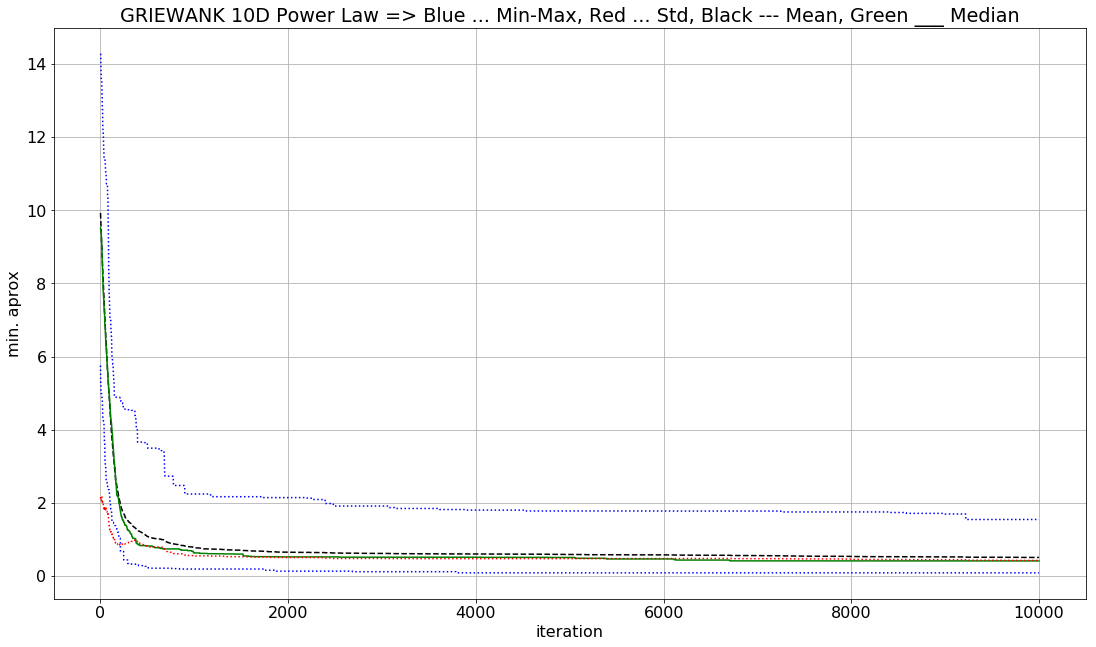

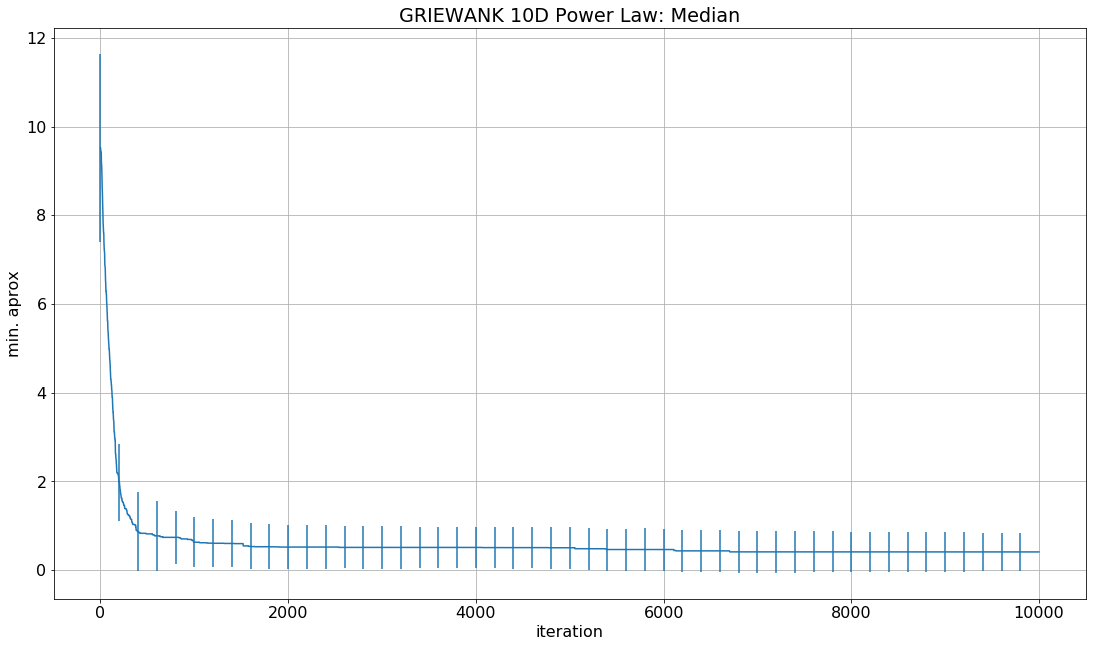

In [117]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-100, high=100, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm = min_GriewankPowerLaw(fevalRdm, x1 = 8.853, x0 = 0.05, alpha = -1.2)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 10D Power Law => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('griewankPowerLaw_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 10D Power Law: Median")
plt.grid()
plt.savefig('griewankPowerLawStd_10d.pdf', format='pdf')
plt.show()

# min_Griewank Hill Climbing
## 2D

 Iteration 29

mean: 1.395248986423409
std: 1.0483325334256566
median: 1.0910331483328184
min: 0.04305809160642704
max: 3.7980103427851923


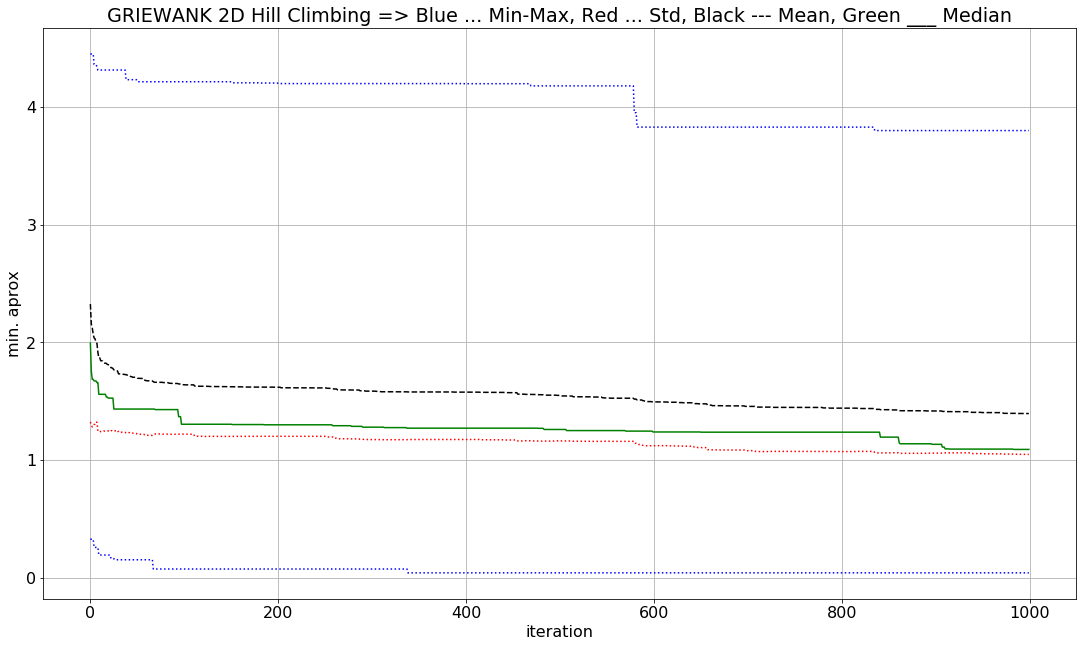

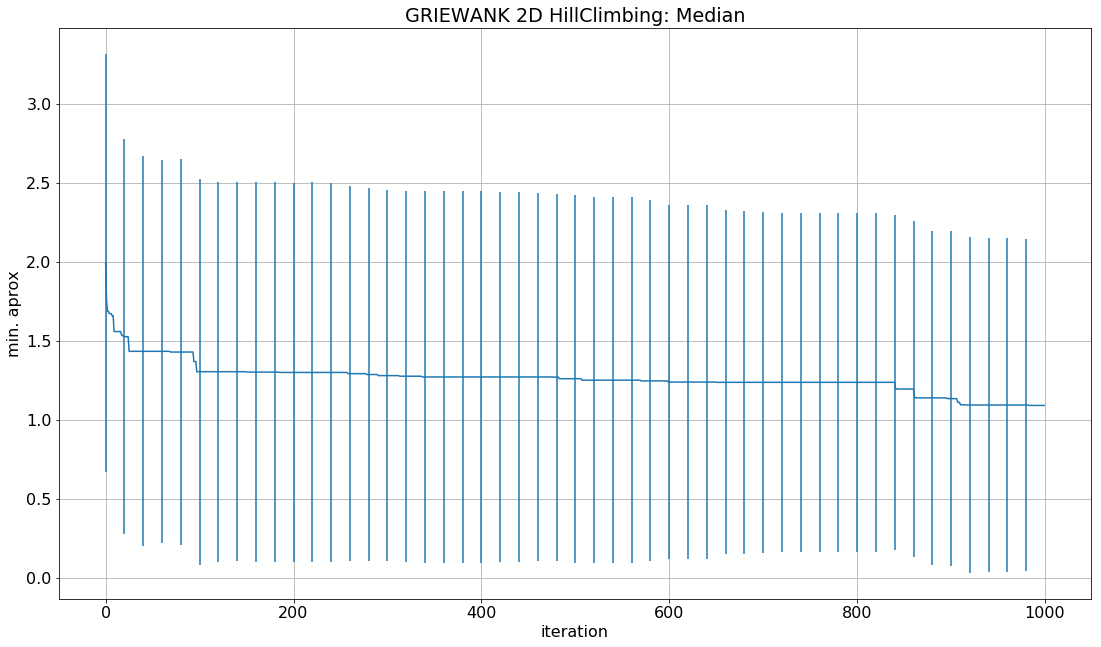

In [123]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-100, high=100, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm = min_GriewankHill(fevalRdm,sigma = 1.81)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 2D Hill Climbing => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('griewankHillClimbing_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 2D HillClimbing: Median")
plt.grid()
plt.savefig('griewankHillClimbingStd_2d.pdf', format='pdf')
plt.show()

# min_Griewank Hill Climbing
## 10D

 Iteration 2

mean: 0.6264884116001063
std: 0.10131726334407909
median: 0.6473014412868551
min: 0.49331017719663084
max: 0.7388536163168329


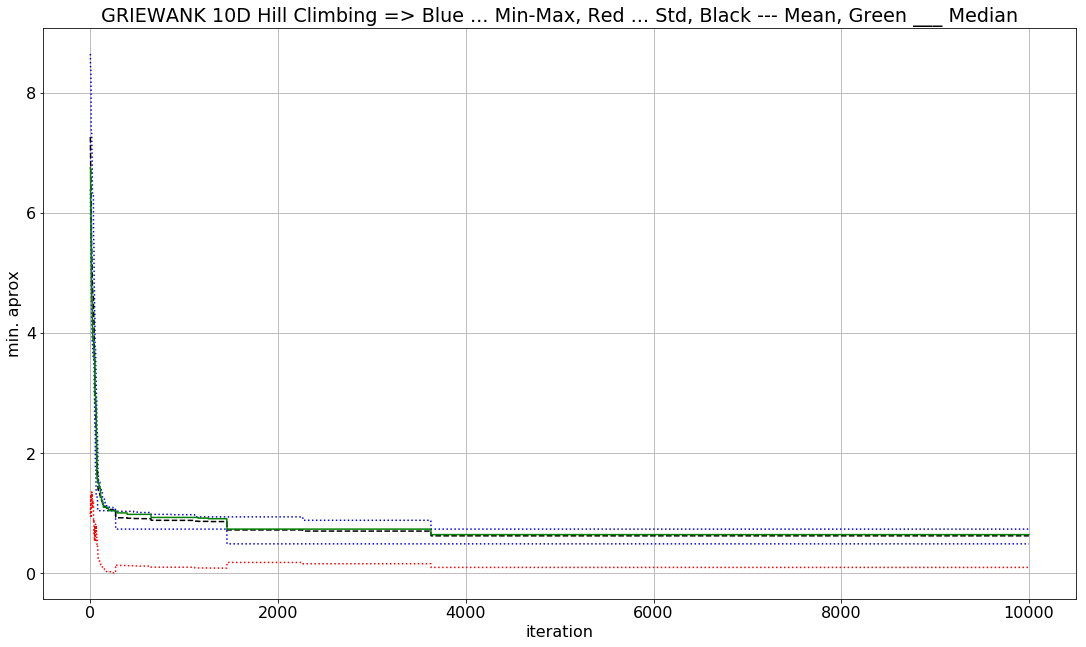

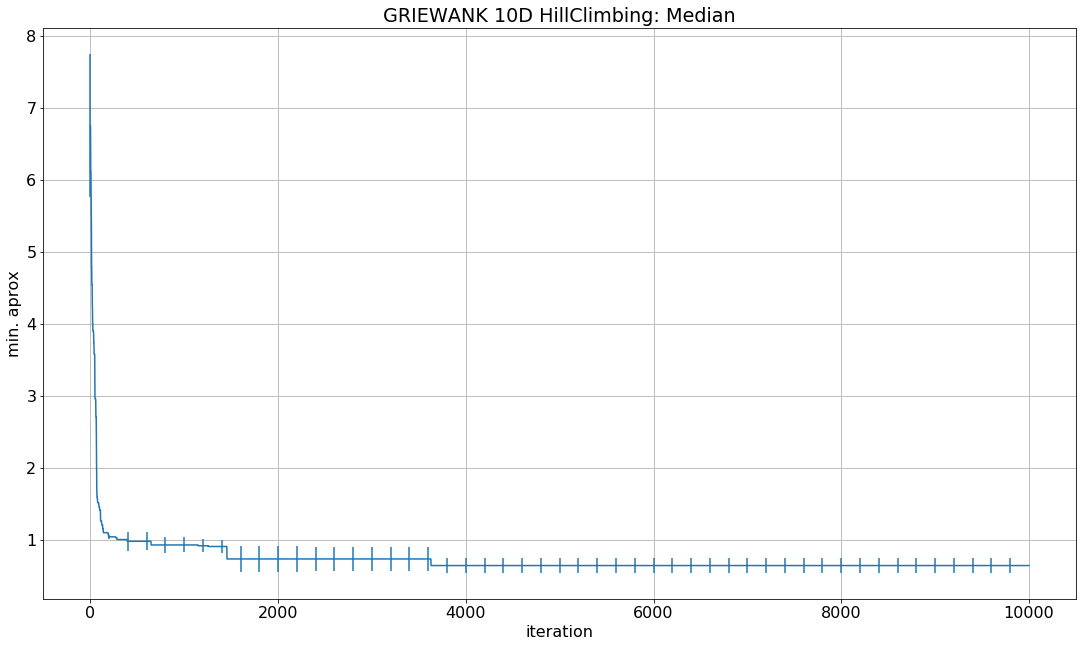

In [132]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 3
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-100, high=100, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm = min_GriewankHill(fevalRdm,sigma = 5.32465478)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 10D Hill Climbing => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('griewankHillClimbing_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 10D HillClimbing: Median")
plt.grid()
plt.savefig('griewankHillClimbingStd_10d.pdf', format='pdf')
plt.show()

# min_Griewank Gradiente
## 2D

 Iteration 29

mean: 1.5388464699492581
std: 0.8176573524027534
median: 1.5123962212776139
min: 0.08874262788901777
max: 3.39245957292209


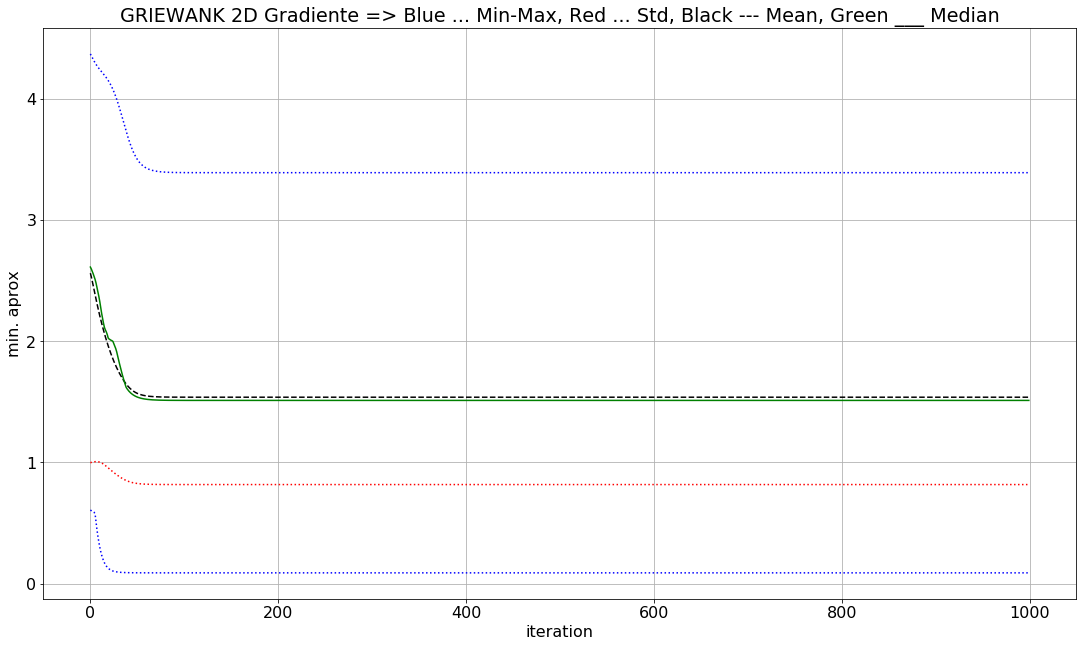

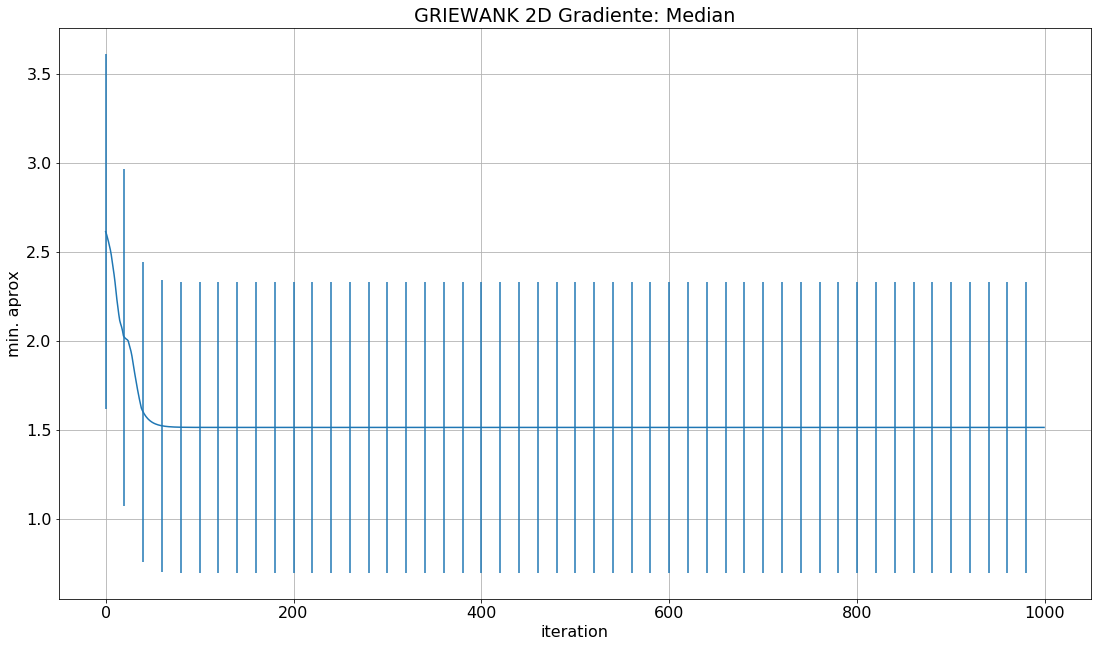

In [138]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-100, high=100, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm, delta = min_GriewankGradiente(fevalRdm,delta,alpha = 0.05, miu = 0.5)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 2D Gradiente => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('griewankGradiente_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 2D Gradiente: Median")
plt.grid()
plt.savefig('griewankGradienteStd_2d.pdf', format='pdf')
plt.show()

# min_Griewank Gradiente
## 10D

 Iteration 29

mean: 7.3483958894484305
std: 2.4163638815025923
median: 7.554839071548534
min: 2.7100834813765324
max: 11.912237992355479


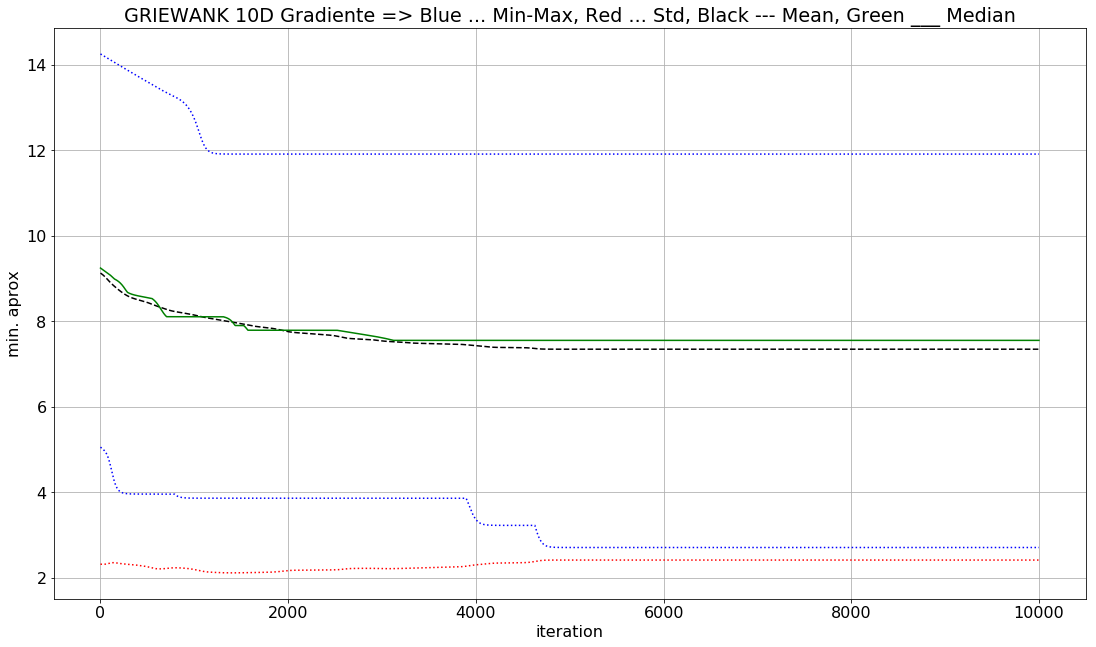

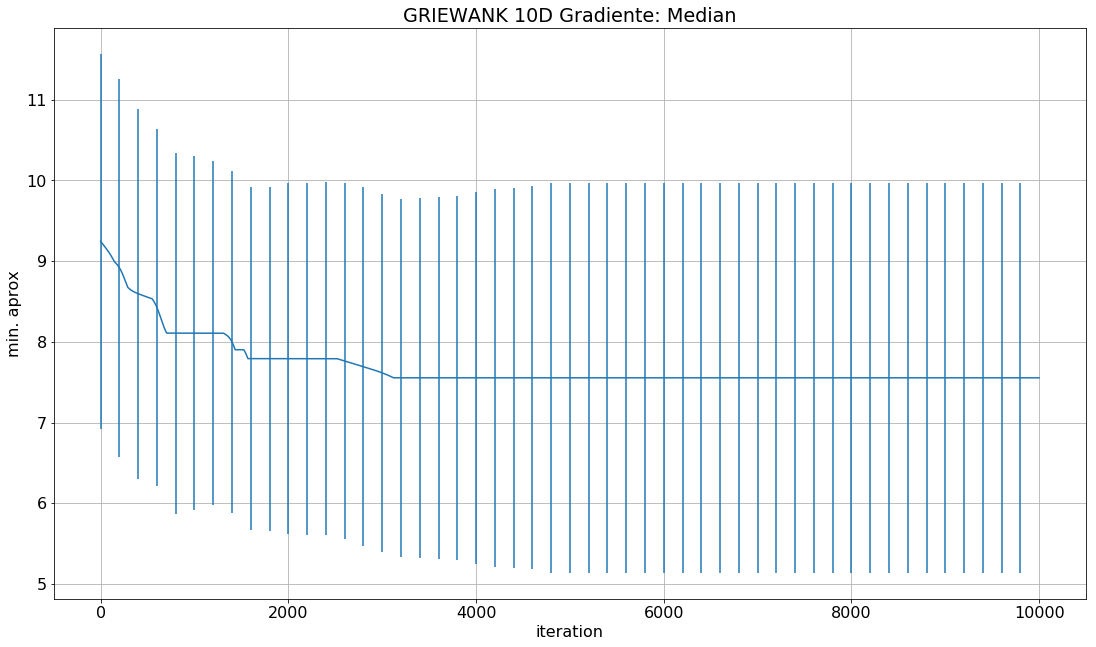

In [154]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-100, high=100, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm, delta = min_GriewankGradiente(fevalRdm,delta,alpha = 0.1, miu = 0.01)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 10D Gradiente => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('griewankGradiente_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 10D Gradiente: Median")
plt.grid()
plt.savefig('griewankGradienteStd_10d.pdf', format='pdf')
plt.show()

# min_Griewank Simulated annealing + Power Law
## 2D

 Temperature 0.013564461456979988

mean: 0.4012862941965751
std: 0.3301924139558016
median: 0.3477222397746854
min: 0.007491272985574282
max: 1.142633597285557


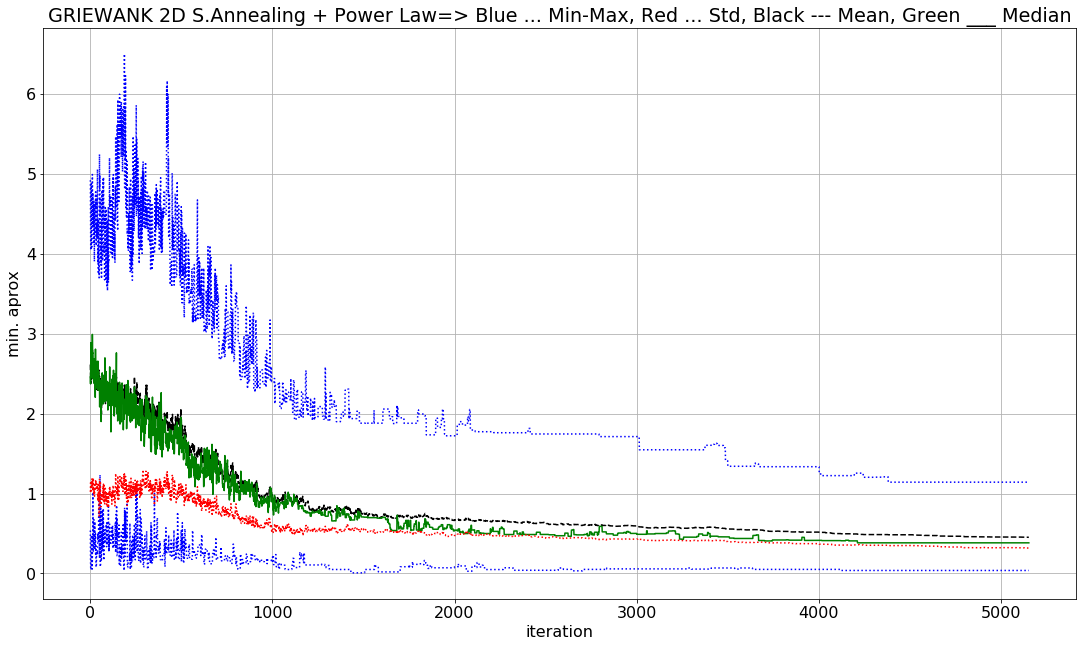

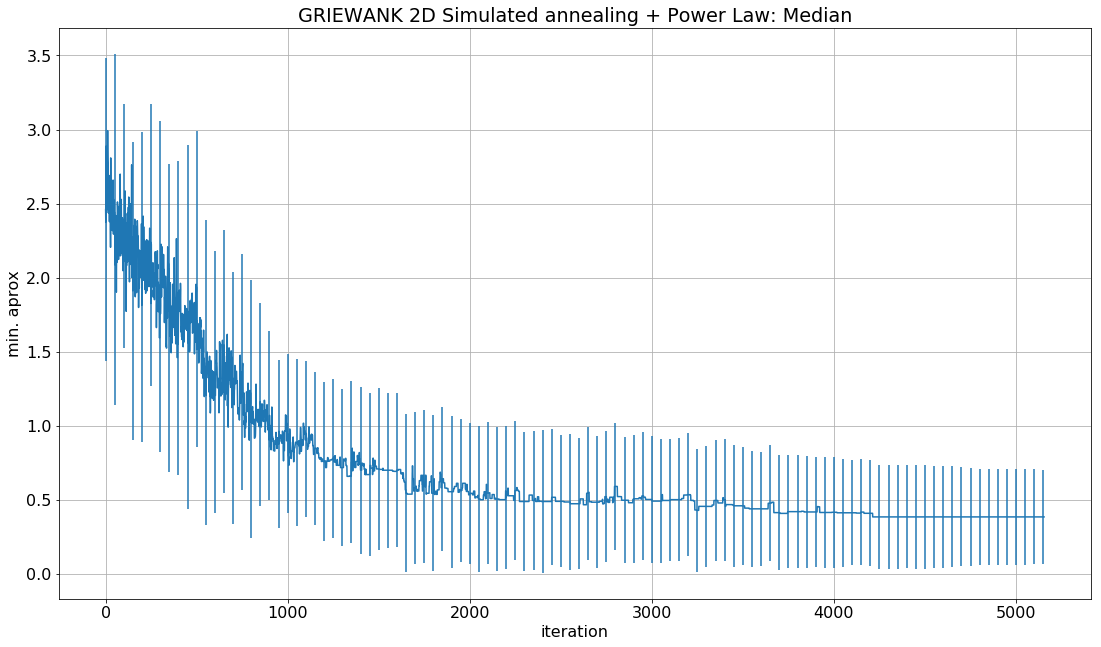

In [190]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 15
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = None
OutIniFlag = False

tf = lambda t: 0.7*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

for j in range(0, repetitions):
    fevalRdm =  np.random.uniform(low=-100, high=100, size=(valVectorSize, 1))
    inits=dict(solution=fevalRdm, length=70, T=2)
    OUT_List_Simanneal_Tmp = []
    bmeta, bs, be, out, OUT_List_Simanneal, Iterations = sa(Griewank,
                                                                inits,
                                                                SimannealItrSize,
                                                                tf,
                                                                itf,
                                                                'rdmSimetricPoerLow',
                                                                sigma = 0.75,
                                                                x1 = 4,
                                                                x0 = 0.5,
                                                                alpha = -1.5)
    
    
    Best_List.append(be)
    if OutIniFlag == False:
        OutIniFlag = True
        OUT_Matrix = np.asarray(OUT_List_Simanneal).reshape(1,-1)
    else:
        OUT_Matrix = np.concatenate((OUT_Matrix, np.asarray(OUT_List_Simanneal).reshape(1,-1)), axis=0)



print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 2D S.Annealing + Power Law=> Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('griewankSAnnealPlw_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:50] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 2D Simulated annealing + Power Law: Median")
plt.grid()
plt.savefig('griewankSAnnealPlwStd_2d.pdf', format='pdf')
plt.show()





# min_Griewank Simulated annealing + Power Law
## 10D

 Temperature 0.0025533525215235803

mean: 0.5574972284342729
std: 0.1197078049165481
median: 0.5553861665691748
min: 0.3223105495175105
max: 0.758361277564934


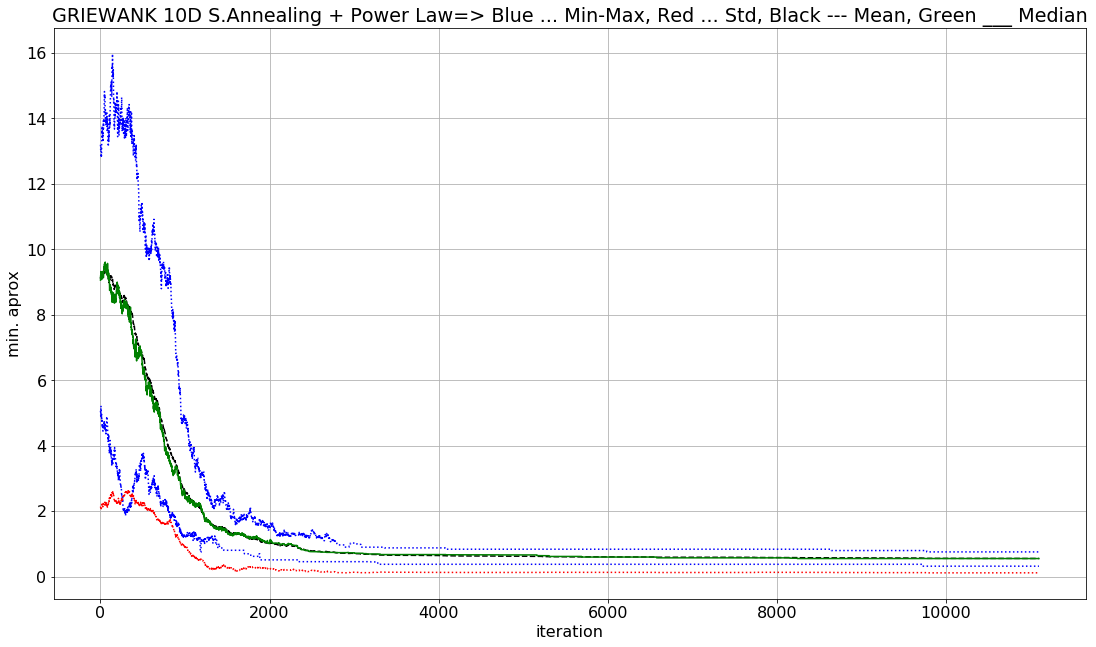

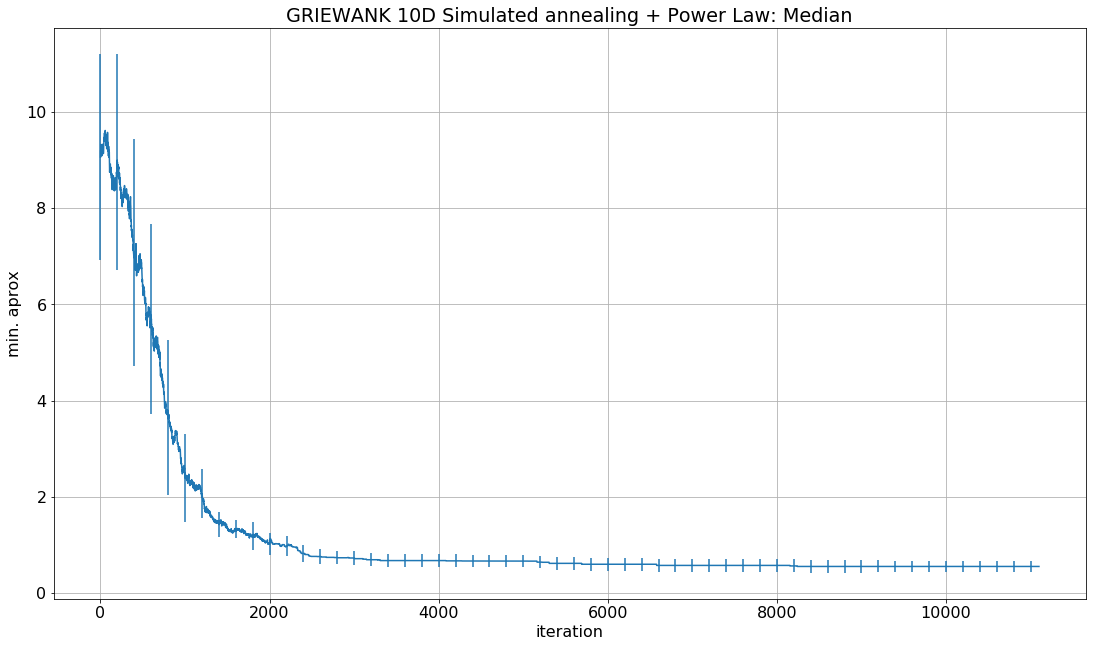

In [178]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = None
OutIniFlag = False

tf = lambda t: 0.7*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

for j in range(0, repetitions):
    fevalRdm =  np.random.uniform(low=-100, high=100, size=(valVectorSize, 1))
    inits=dict(solution=fevalRdm, length=70, T=1.568)
    OUT_List_Simanneal_Tmp = []
    bmeta, bs, be, out, OUT_List_Simanneal, Iterations = sa(Griewank,
                                                                inits,
                                                                SimannealItrSize,
                                                                tf,
                                                                itf,
                                                                'rdmSimetricPoerLow',
                                                                sigma = 0.75,
                                                                x1 = 3,
                                                                x0 = 0.5,
                                                                alpha = -1.5)
    
    
    Best_List.append(be)
    if OutIniFlag == False:
        OutIniFlag = True
        OUT_Matrix = np.asarray(OUT_List_Simanneal).reshape(1,-1)
    else:
        OUT_Matrix = np.concatenate((OUT_Matrix, np.asarray(OUT_List_Simanneal).reshape(1,-1)), axis=0)



print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 10D S.Annealing + Power Law=> Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('griewankSAnnealPlw_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 10D Simulated annealing + Power Law: Median")
plt.grid()
plt.savefig('griewankSAnnealPlwStd_10d.pdf', format='pdf')
plt.show()






# min_Griewank Simulated annealing + Normal
## 2D

 Temperature 0.027993599999999997

mean: 1.503057535759417
std: 1.030089630484402
median: 1.49430068065833
min: 0.007720245771060008
max: 3.5798963333257583


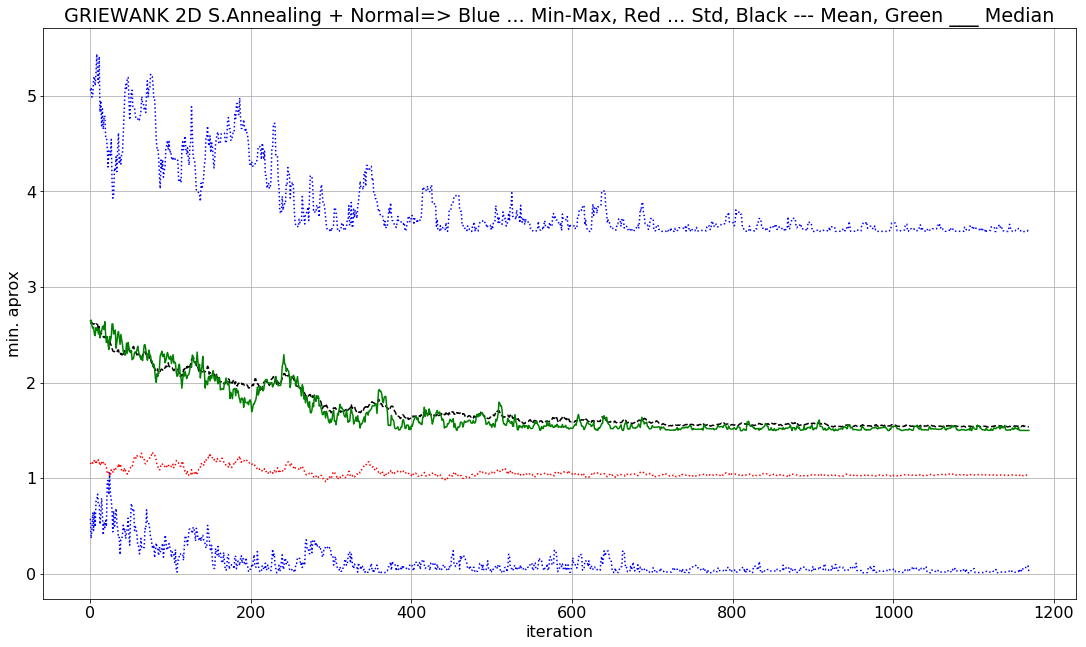

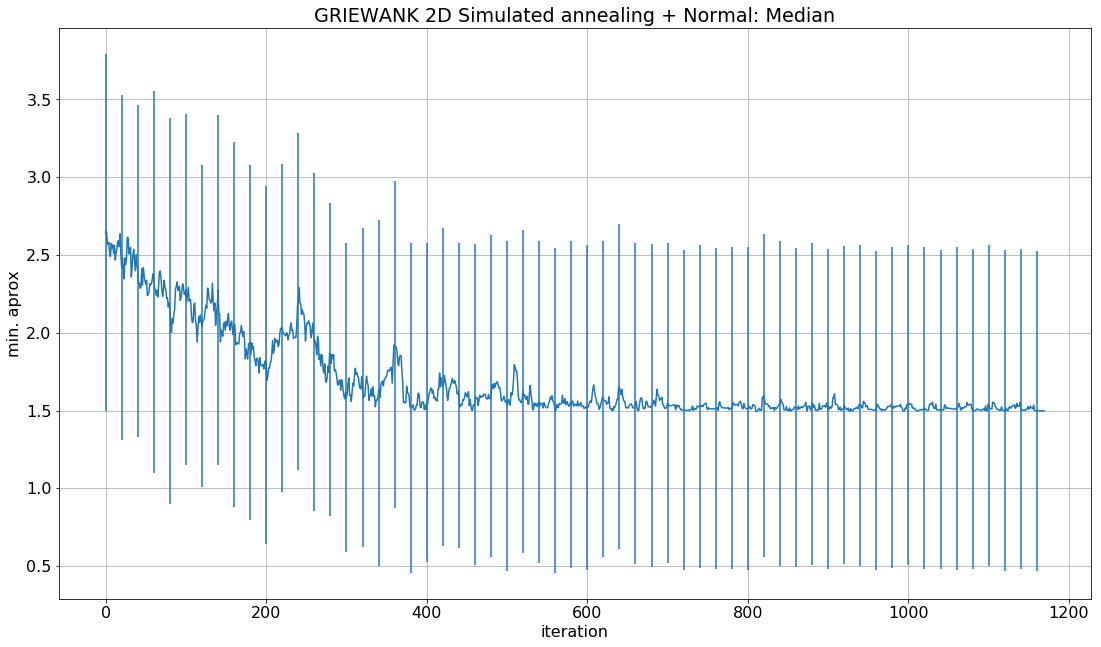

In [204]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = None
OutIniFlag = False

tf = lambda t: 0.6*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

for j in range(0, repetitions):
    fevalRdm =  np.random.uniform(low=-100, high=100, size=(valVectorSize, 1))
    inits=dict(solution=fevalRdm, length=70, T=1)
    
    bmeta, bs, be, out, OUT_List_Simanneal, Iterations = sa(Griewank,
                                                                inits,
                                                                SimannealItrSize,
                                                                tf,
                                                                itf,
                                                                'rdmGauss',
                                                                sigma = 0.25,
                                                                x1 = 20,
                                                                x0 = 0.5,
                                                                alpha = -1.5)
    
    
    Best_List.append(be)
    if OutIniFlag == False:
        OutIniFlag = True
        OUT_Matrix = np.asarray(OUT_List_Simanneal).reshape(1,-1)
    else:
        OUT_Matrix = np.concatenate((OUT_Matrix, np.asarray(OUT_List_Simanneal).reshape(1,-1)), axis=0)



print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 2D S.Annealing + Normal=> Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('griewankSAnnealNrm_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 2D Simulated annealing + Normal: Median")
plt.grid()
plt.savefig('griewankSAnnealNrmStd_2d.pdf', format='pdf')
plt.show()






# min_Griewank Simulated annealing + Normal
## 10D

 Temperature 0.0018014398509482003

mean: 6.463648760619689
std: 2.57021173499571
median: 6.569787648052804
min: 1.6233380750461528
max: 13.232141018571015


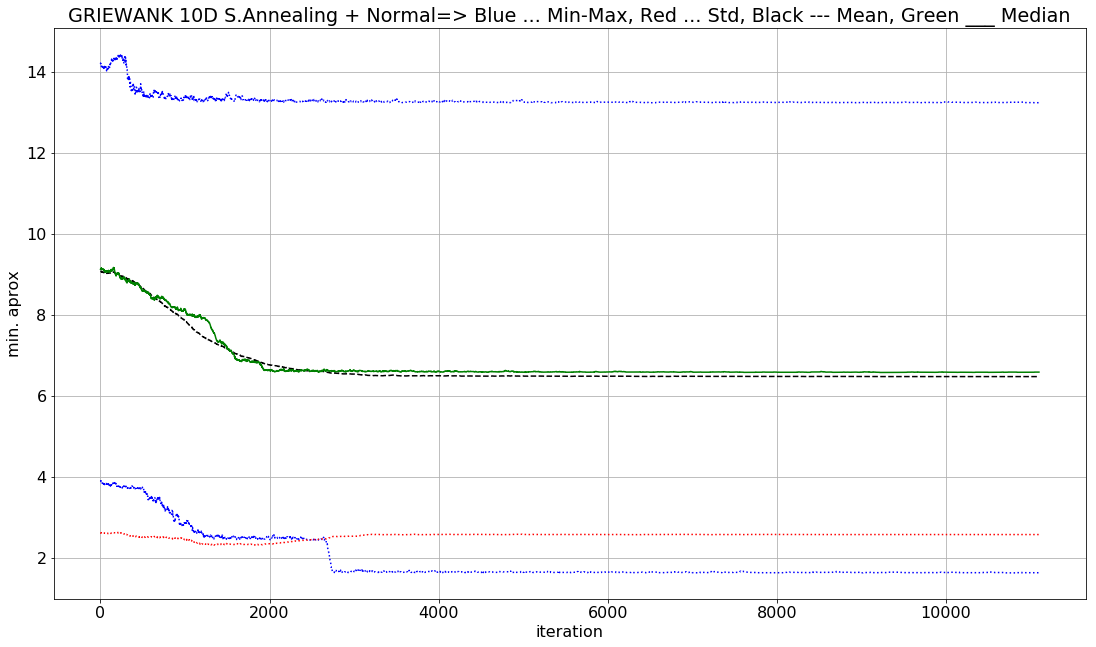

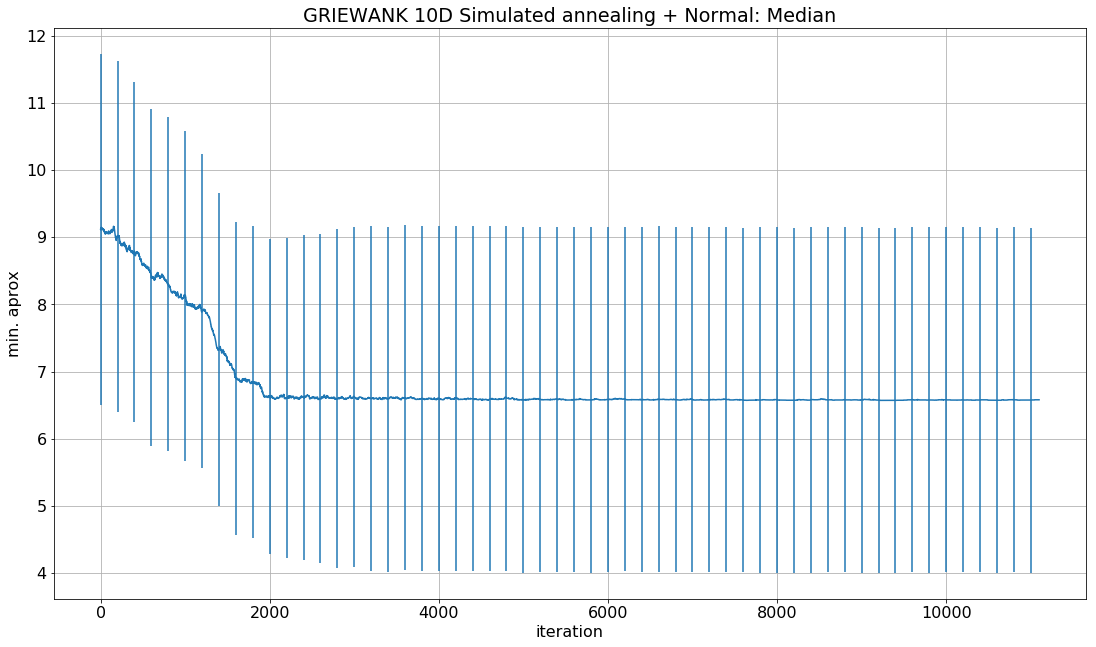

In [206]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = None
OutIniFlag = False

tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

for j in range(0, repetitions):
    fevalRdm =  np.random.uniform(low=-100, high=100, size=(valVectorSize, 1))
    inits=dict(solution=fevalRdm, length=70, T=0.1)
    
    bmeta, bs, be, out, OUT_List_Simanneal, Iterations = sa(Griewank,
                                                                inits,
                                                                SimannealItrSize,
                                                                tf,
                                                                itf,
                                                                'rdmGauss',
                                                                sigma = 0.1234,
                                                                x1 = 20,
                                                                x0 = 0.5,
                                                                alpha = -1.5)
    
    
    Best_List.append(be)
    if OutIniFlag == False:
        OutIniFlag = True
        OUT_Matrix = np.asarray(OUT_List_Simanneal).reshape(1,-1)
    else:
        OUT_Matrix = np.concatenate((OUT_Matrix, np.asarray(OUT_List_Simanneal).reshape(1,-1)), axis=0)



print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 10D S.Annealing + Normal=> Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('griewankSAnnealNrm_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("GRIEWANK 10D Simulated annealing + Normal: Median")
plt.grid()
plt.savefig('griewankSAnnealNrmStd_10d.pdf', format='pdf')
plt.show()





